In [88]:
import torch

def qrcp(B):
    A = B.t() #the transpose
    m, n = A.shape
    Q = torch.eye(m, m, dtype=A.dtype, device=A.device)
    R = A.clone()
    P = torch.arange(n, dtype=torch.long, device=A.device)
    
    for i in range(min(m, n)):
        # Find the pivot - the column with the largest norm
        norms = torch.norm(R[i:, i:], dim=0)
        max_norm_col = torch.argmax(norms) + i
        # Swap columns in R and rows in P
        R[:, [i, max_norm_col]] = R[:, [max_norm_col, i]]
        P[i], P[max_norm_col] = P[max_norm_col].item(), P[i].item()
        
        # Compute the Householder transformation for the current column
        x = R[i:, i]
        rho = -torch.sign(x[0]) if x[0] != 0 else -1
        s = torch.sqrt(0.5 * (1 + abs(rho) * x[0] / torch.norm(x)))
        v = torch.zeros_like(x)
        v[0] = s
        u = (x - rho * v) / (s * x[0])
        v = u - v
        
        # Apply the transformation to R and Q
        R[i:, i:] -= 2 * v.outer(v @ R[i:, i:])
        Q[:, i:] -= 2 * (Q[:, i:] @ v).outer(v)
    
    # Adjust Q, R based on the permutation P
    #P_matrix = torch.eye(n, dtype=A.dtype, device=A.device)[P]
    return P

# Example usage
A = torch.rand(4, 3)  # Random 4x3 matrix
P_index = qrcp(A)

# print("Q:", Q)
# print("R:", R)
# print("P:", P)
print("P_idx:", P_index)


P_idx: tensor([3, 2, 1, 0])


In [89]:
import torch


def attach_qr_coreset_split(coresets, sub_train_loader, num_samples=200):

    dataset = sub_train_loader.dataset
    task_indices = sub_train_loader.sampler.indices
    A = torch.stack([dataset[i][0].flatten().float() for i in task_indices])

    P_indices = qrcp(A)

    coreset_indices = task_indices[P_indices[:num_samples]]

    sub_train_loader.sampler.indices = task_indices[P_indices[num_samples:]]

    # Create a new sampler for the coreset based on the selected indices
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    
    # Create a new DataLoader for the coreset
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, 
        batch_size=sub_train_loader.batch_size, 
        sampler=coreset_sampler)
    
    # Append the new coreset DataLoader to the list of existing coresets
    coresets.append(coreset_loader)


A simple test

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [91]:


# # Step 1: Create a simple synthetic dataset
class SyntheticDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], 0  # Returning 0 as a dummy label

# Sample data: 10 points in 2D space
data = torch.tensor([[1.0, 2.0, 1.0], [2.0, 1.0,3.0], [2.0, 4.0,3.0], [4.0, 2.0,3.0],
                     [3.0, 3.0,3.0], [1.0, 3.0,3.0], [4.0, 1.0,3.0], [4.0, 4.0,3.0],
                     [3.0, 1.0,3.0], [1.0, 4.0,3.0]])

dataset = SyntheticDataset(data)

# dataset_size = len(dataset)
# indices = list(range(dataset_size))
# sampler = SubsetRandomSampler(indices)

# # Step 2: Prepare DataLoader
# loader = DataLoader(dataset, batch_size=2, sampler=sampler)


# # Step 3: Prepare a list to hold coresets (though it will hold only one for this test)
# c = []

# # Assuming attach_kCenter_coreset_split is correctly defined as per your requirement
# attach_qr_coreset_split(c, loader, num_samples=4)

# # Step 4: Verify the selected coreset
# print("Coreset Indices:", c[0].sampler.indices)
# print("Dataset Indices:", loader.sampler.indices)


TypeError: only integer tensors of a single element can be converted to an index

Now, lets test performing it twice

In [92]:
data = torch.tensor([[1.0, 2.0, 1.0], [2.0, 1.0,3.0], [2.0, 4.0,3.0], [4.0, 2.0,3.0],
                     [3.0, 3.0,3.0], [1.0, 3.0,5.0], [4.0, 1.0,3.0], [4.0, 4.0,3.0],
                     [3.0, 1.0,3.0], [1.0, 4.0,3.0]])

dataset = SyntheticDataset(data)

dataset_size = len(dataset)
indices = list(range(dataset_size))
sampler = SubsetRandomSampler([1,2,3,4,5,6,7,8,9])
loader = DataLoader(dataset, batch_size=2, sampler=sampler)
c = []
# Assuming attach_kCenter_coreset_split is correctly defined as per your requirement
attach_qr_coreset_split(c, loader, num_samples=2)

# Step 4: Verify the selected coreset
print("Coreset Indices:", c[0].sampler.indices)
print("Dataset Indices:", loader.sampler.indices)


attach_qr_coreset_split(c, loader, num_samples=3)

# Step 4: Verify the selected coreset
print("Coreset Indices:", c[1].sampler.indices)
print("Dataset Indices:", loader.sampler.indices)

TypeError: only integer tensors of a single element can be converted to an index

## Visualize

In [97]:
import dataset
import coresets

not_mnist = True
class_distribution = [[0, 1],[2, 3],[4, 5],[6, 7],[8, 9]]
batch_size = 250
num_samples = 10


In [ ]:
dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
trainloader, testloader = dataloaders[0]

c = []

attach_qr_coreset_split(c, trainloader, num_samples=num_samples)
c[0].sampler.indices

In [ ]:
import coresets
dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
trainloader, testloader = dataloaders[0]
c_k = []
num_samples = 10
coresets.attach_kCenter_coreset_split(c_k, trainloader, num_samples=num_samples)
c_k[0].sampler.indices

tensor([42435, 41358, 35505, 54943, 37738, 23104, 16485, 26184, 49889,    68])

In [ ]:
dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
trainloader, testloader = dataloaders[0]
c_r = []
num_samples = 10
coresets.attach_random_coreset_split(c_r, trainloader, num_samples=num_samples)
c_r[0].sampler.indices

tensor([36562, 37787, 56101, 42634, 52878, 31369, 59156, 57714, 11715, 10741])

In [ ]:
import matplotlib.pyplot as plt

# image = trainloader.dataset[3][0][0] #0 indicates whe want x not (x,y)
# fig = plt.figure
# plt.imshow(image, cmap='gray')
# plt.show()

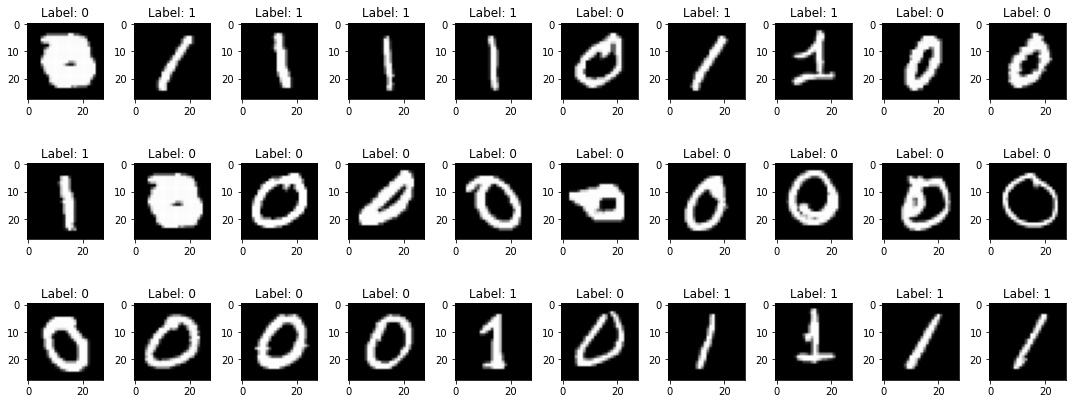

In [ ]:
num_row = 3
num_col = num_samples


# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
trainloader, testloader = dataloaders[0]
images = [trainloader.dataset[idx][0][0] for idx in c[0].sampler.indices]
labels = [trainloader.dataset[idx][1] for idx in c[0].sampler.indices]
for i in range(num_col):
    #ax = axes[i//num_col, i%num_col]
    ax = axes[0, i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))

images = [trainloader.dataset[idx][0][0] for idx in c_k[0].sampler.indices]
labels = [trainloader.dataset[idx][1] for idx in c_k[0].sampler.indices]
for i in range(num_col):
    #ax = axes[i//num_col, i%num_col]
    ax = axes[1, i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))

images = [trainloader.dataset[idx][0][0] for idx in c_r[0].sampler.indices]
labels = [trainloader.dataset[idx][1] for idx in c_r[0].sampler.indices]
for i in range(num_col):
    #ax = axes[i//num_col, i%num_col]
    ax = axes[2, i]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))

plt.tight_layout()
plt.show()

Testing on the model !!!!

In [ ]:
import torch

import vcl
import dataset
import coresets
import numpy as np
from models import MultiheadModel

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_tasks = 5
num_epochs = 10 # 100 or 10
single_head = False
batch_size = 256

class_distribution = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7],
    [8, 9],
]
dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
model = MultiheadModel(28*28)
model.to(device)

# # Vanilla VCL - no coreset
# coreset_size = 0
# coreset_method = coresets.attach_random_coreset_split
# vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)

# QR Coreset VCL

# coreset_size = 40
# coreset_method = attach_qr_coreset_split
# all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("QR Coreset VCL")
# print("Average accuracy after each task:", accs)

# # Random Coreset VCL
# coreset_size = 200
# coreset_method = coresets.attach_random_coreset_split
# vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)

# K-Center Coreset VCL

# coreset_size = 40
# coreset_method = coresets.attach_kCenter_coreset_split
# all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("K-Center Coreset VCL")
# print("Average accuracy after each task:", accs)

# Random Coreset Only
# coreset_size = 200
# coreset_method = coresets.attach_random_coreset_split
# all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("Average accuracy after each task:", accs)

# K-center Coreset Only

# coreset_size = 200
# coreset_method = coresets.attach_kCenter_coreset_split
# all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("K-center Coreset Only")
# print("Average accuracy after each task:", accs)

# QR-coreset Only

coreset_size = 200
coreset_method = attach_qr_coreset_split
all_accs = vcl.run_coresetonly(num_tasks, single_head, num_epochs, dataloaders,
            model, coreset_method, coreset_size, beta=0.01)
accs = np.nanmean(all_accs, axis=1)
print("QR Coreset Only")
print("Average accuracy after each task:", accs)
#Better batch
# joint_class_distribution = [
#     [0, 1],
#     [0, 1, 2, 3],
#     [0, 1, 2, 3, 4, 5],
#     [0, 1, 2, 3, 4, 5, 6, 7],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
# ]
# dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
# coreset_size = 0 #irrelevant
# coreset_method = coresets.attach_kCenter_coreset_split #irrelevant
# all_accs = vcl.run_vcl(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("Average accuracy after each task:", accs)


# # Batch??? vcl.run_full
# joint_class_distribution = [
#     [0, 1],
#     [0, 1, 2, 3],
#     [0, 1, 2, 3, 4, 5],
#     [0, 1, 2, 3, 4, 5, 6, 7],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
# ]
# dataloaders = dataset.SplitMnistDataloader(class_distribution, batch_size, not_mnist)
# coreset_size = 0 #irrelevant
# coreset_method = coresets.attach_kCenter_coreset_split #irrelevant
# all_accs = vcl.run_full(num_tasks, single_head, num_epochs, dataloaders,
#             model, coreset_method, coreset_size, beta=0.01)
# accs = np.nanmean(all_accs, axis=1)
# print("Average accuracy after each task:", accs)




Starting Task 1
Replaying Task 1


100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Done Training Coreset 1
Task 1 Accuracy: 0.9471263474295191

Starting Task 2
Replaying Task 1


100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Done Training Coreset 2
Replaying Task 2


100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


Done Training Coreset 2
Task 1 Accuracy: 0.9719436670812603
Task 2 Accuracy: 0.6812734375

Starting Task 3
Replaying Task 1


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


Done Training Coreset 3
Replaying Task 2


100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Done Training Coreset 3
Replaying Task 3


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Done Training Coreset 3
Task 1 Accuracy: 0.9803456674958542
Task 2 Accuracy: 0.7996953125
Task 3 Accuracy: 0.7173208841463414

Starting Task 4
Replaying Task 1


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Done Training Coreset 4
Replaying Task 2


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Done Training Coreset 4
Replaying Task 3


100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Done Training Coreset 4
Replaying Task 4


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Done Training Coreset 4
Task 1 Accuracy: 0.9887930140961857
Task 2 Accuracy: 0.846734375
Task 3 Accuracy: 0.8052591463414633
Task 4 Accuracy: 0.7633094394329897

Starting Task 5
Replaying Task 1


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Done Training Coreset 5
Replaying Task 2


100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


Done Training Coreset 5
Replaying Task 3


100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


Done Training Coreset 5
Replaying Task 4


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Done Training Coreset 5
Replaying Task 5


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Done Training Coreset 5
Task 1 Accuracy: 0.9926992640961857
Task 2 Accuracy: 0.87708984375
Task 3 Accuracy: 0.8434046303353658
Task 4 Accuracy: 0.838404075386598
Task 5 Accuracy: 0.6989835569371727

[[0.94712635        nan        nan        nan        nan]
 [0.97194367 0.68127344        nan        nan        nan]
 [0.98034567 0.79969531 0.71732088        nan        nan]
 [0.98879301 0.84673438 0.80525915 0.76330944        nan]
 [0.99269926 0.87708984 0.84340463 0.83840408 0.69898356]]
QR Coreset Only
Average accuracy after each task: [0.94712635 0.82660855 0.83245395 0.85102399 0.85011627]
